## Phylogenetic Analysis

The goal of this notebook is to perform phylogenetic inference on the samples from the boat as well as other genomes sampled from around the same time as the boat outbreak. 

**Requirements:**
Make sure you have `Biopython`, `MAFFT`, `BLAST`, and `ETE3` installed in your environment. 

In [53]:
import pandas as pd
from io import StringIO 
import os 
from Bio import SeqIO, AlignIO, SeqRecord, Seq # Parse fasta files 
from itertools import combinations # Handle pairwise comparisons
from collections import Counter # Count instances in a list
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, SequenceFace # Tree visualization
from subprocess import call # Run commands in Unix
import itertools
# Make sure mafft is in the conda/local env
from Bio.Align.Applications import MafftCommandline

# Change the directory if running interactivley
%cd /fh/fast/bloom_j/computational_notebooks/whannon/2020/SARS-CoV-2_bottleneck


/fh/fast/bloom_j/computational_notebooks/whannon/2020/SARS-CoV-2_bottleneck


In [2]:
# Important paths
outpath = "results/phylogeny"

if not os.path.exists(outpath):
    os.mkdir(outpath)

### Boat Analysis

This first part of the notebook contains an analysis of the genomes collected from the boat and sequenced twice from two different reverse transcription experiments. 

To make the consensus sequences, I took each `BAM` file and counted the occurences of each nucleotide at every position. If there were less than 100 reads that covered a given site (with `BQ > 25`) then I coded this site as an `N`. Then, using both replicates, I filled in missing (`N`) nucleotides with the more highly covered positions. 

This method doesn't take into account insertions and deletions. That could be a bit of a shortcoming, however, I can also include insertions and deletions if necessary. Since I'm mostly focused on SNPs in the intrahost population, I thoguht this was a reasonable oversight.

In [3]:
# Path to the aligned sequences
boat_genomes_path = "results/consensus/aligned_consensus.fa"
# Put the sequence records and ids into a dictionary structure
boat_genomes = {record.id : record.seq for record in SeqIO.parse(boat_genomes_path, "fasta")}


#### Edit Distance

Here is the edit distance (hamming distance) between each of the genomes. The most divergent sample is `10136`. We know that this sample probably wasn't infected by the same virus that spread on the boat. It also doesn't seem like any of the cases on the boat came from this person. On average, there are about 2 nucleotide differences between all samples, expect for `10136` which averages ~9 differences per sample. 

In [4]:
distance = lambda x,y : sum(c1 != c2 for c1, c2 in zip(x, y))

edit_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2)}
outlier_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2) if g1 == '10136' or g2 == '10136'}

print(f"The mean pairwise distance between samples is {sum(v for v in edit_distance.values()) / len(edit_distance):.2f}.\n")
print(f"However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of {sum(v for v in outlier_distance.values()) / len(outlier_distance):.2f} from any other sample.")


The mean pairwise distance between samples is 2.13.

However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of 8.83 from any other sample.


#### Consensus Differences 

Here are all the differences between the 24 patients and the reference (Wuhan-1). I collapsed patients with the same consensus sequecnes into a single row. A better way to visualize this might be to add it to a phylogenetic tree of the samples on the boat as an annotation. 

Some of these sites are different from the reference, but the same in all 24 individuals (boat consensus mutations). I could either include or exclude these from the visualization. I'm not sure what's best. 

Of the 24 samples, there are two clusters of identical genomes, one has

In [30]:
# Reference Sequence 
reference = [base for record in SeqIO.parse("config/ref/SARS2.fa", "fasta") for base in record.seq]

# Save a dict of the consensus SNPs for each patient
consesus = {}

# Populate the dict
for patient, genome in boat_genomes.items():
    differences = []
    for i, bases in enumerate(zip(reference, genome.upper())):
        if len(set(bases)) > 1: 
            differences.append((i, bases))
    consesus[patient] = differences

# Get a set of all unique SNPs 
consensus_differences = set(snp for snp_list in consesus.values() for snp in snp_list)

# Fill in the missing SNPs in the dict
for patient, snps in consesus.items(): 
    for snp in consensus_differences: 
        if snp not in snps:
            consesus[patient].append((snp[0], (snp[1][0], snp[1][0])))

# Condense the identical sequences
unique_consensus = {}

for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][1] for snp in sorted(snps, key = (lambda s: s[0]))])
    if con in unique_consensus.keys():
        unique_consensus[con].append(patient)
    else: 
        unique_consensus[con] = [patient]

# Print the differences for each patient 
print(f"Position: {' '.join([str(snp[0]) for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
print(f"Reference: \t\t\t\t{' '.join([snp[1][0] for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")

for snps, patients in unique_consensus.items(): 
    print(f"{'/'.join(patients)}: \t\t\t\t\t{snps}")


Position: 240 538 1058 1254 3036 6045 7563 8289 11082 13251 13422 14407 16911 17124 17155 17351 19523 23402 25562 27310 28375 29166 29298 29552 29867 29869
Reference: 				C C C A C T C C G C C C G C C C C A G T G C A G G C
10114: 					T C T A T T T C T C C T G C C C T G T T T C A G G A
10117/10118/10127/10130/10027/10040/10089/10091/10102/10110: 					T C T A T T T C T C C T G C C C C G T T T C A G G A
10128: 					T C T A T T T T T C C T G T C C C G T T T C A G G A
10129: 					T C T A T T T T T C C T G C C C C G T T T C A G G C
10131: 					T T T A T T T C T C C T G C C C C G T C T C A G G A
10136: 					T C T G T C C C G C C T T C T C C G T T G C A A G A
10138: 					T C T A T T T C T C C T G C C C C G T T T C T G G A
10028: 					T C T A T T T T T C C T G C C C C G T T T C A G A A
10029/10094/10106: 					T C T A T T T C T C C T G C C C C G T T T C A G A A
10039: 					T C T A T T T C T C C T G C C C C G T T T T A G A A
10042: 					T C T A T T T C T C T T G C C T C G T T T C A G G A
10088: 

#### Boat Consensus 

These are the mutations that are different from the reference, but shared between all 24 people we've analyzed on the boat. 

In [32]:
# Consensus in all samples including divergent 10136
all_boat_consensus = []
for k,v in Counter(snp for snps in consesus.values() for snp in snps).items():
    if v == 24:
        all_boat_consensus.append(k)
    
# Consensus in all samples EXCLUDING divergent 10136
true_boat_consensus = []
for k,v in Counter(snp for patient, snps in consesus.items() if patient != "10136" for snp in snps).items():
    if v == 23:
        true_boat_consensus.append(k)

print(f"Mutations found in every patient including 10136:\n\t{[''.join([alleles[0], str(pos+1), alleles[1]]) for pos, alleles in all_boat_consensus]}\n")
print(f"Mutations found in every patient EXCLUDING 10136:\n\t{[''.join([alleles[0], str(pos+1), alleles[1]]) for pos, alleles in true_boat_consensus]}\n")



Mutations found in every patient including 10136:
	['C241T', 'C1059T', 'C3037T', 'C14408T', 'A23403G', 'G25563T']

Mutations found in every patient EXCLUDING 10136:
	['C241T', 'C1059T', 'C3037T', 'C7564T', 'G11083T', 'C14408T', 'A23403G', 'G25563T', 'G28376T', 'G16912G', 'C17156C', 'T6046T', 'A1255A', 'G29553G']



#### Boat Phylogenetic Tree

Here I make a tree from the consensus samples deep-sequenced from the boat. The tree was made using IQtree's automatic model using the commad `iqtree -s {input}`.  

I annotated the tree with the differences from the reference. 

In [123]:
def mask_positions(record, positions = [265, 29675]):
    """
    Positions to exclude from the ends of the genome for alignments and phylogenetics. 
    
    For now, the default will be to exclude the 3' and 5' UTRs. 
    """
    
    record.seq = record.seq[positions[0]:positions[1]]
    
    return record


def make_tree(fastapath, outpath, prefix, referencepath = "config/index/samtools/SARS2.fa", large = True, mask = True):
    """
    Function to align sequences and build a phylogenetic tree. Alignment is 
    performed using MAFFT and tree is built with IQtree. 
    """
    # Path to aligned fasta
    alignfasta = f"{outpath}/{prefix}.aligned.fa"
    
    # Align the samples with MAFFT
    print(f"Aligning the fasta file: {fastapath}\n")
    
    if large:
        # Align to a reference when there are many sequences
        call(f"mafft --6merpair --thread {4} --keeplength --addfragments {fastapath} {referencepath} > {alignfasta}", shell=True)
    
    else: 
        # Otherwise just use the default mafft. 
        mafft_cline = MafftCommandline(input=fastapath)
        stdout, stderr = mafft_cline()

        # Write the aligned sequences to a fasta file
        with open(alignfasta, "w") as handle:
            handle.write(stdout)
        
    print(f"Finshed aligning file. Alignment is located at {alignfasta}\n")
    
    # Mask the 3' and 5' UTRs if desired
    if mask:
        SeqIO.write([mask_positions(record) for record in SeqIO.parse(alignfasta, "fasta")], alignfasta, "fasta")
    
    print(f"Building treefile: {alignfasta}.treefile\n")
    
    # Build the phylogeny with IQtree with 1000 bootstrap iterations with GTR+I+G (Invariable site plus discrete Gamma model)
    # Also, do ancestral state reconstruction on the tree. 
    call(f"iqtree -s {alignfasta} -m GTR+I+G -bb 1000 -asr -st DNA -redo", shell=True)
    
    print(f"Finished building treefile.\n")


I rooted the tree using the midpoint. You can see that `10136` is the outgroup as expected. This figure shows the phylogenetic relationship between the samples on the boat along with the nucleotide differences from the reference. I need to add the positions in adobe illustrator.

In [105]:
if not os.path.exists("results/phylogeny/merged.consenus.aligned.fa.treefile"):
    
    make_tree(fastapath = "results/consensus/merged.consenus.fa", outpath = outpath, prefix = "merged.consenus", large = False, mask = False)


## == Import the tree file == ##
t = Tree("results/phylogeny/merged.consenus.aligned.fa.treefile")   

## == Root the tree using midpoint rooting == ## 
# With midpoint rooting you can see that 10136 is distant from the rest of the sequences. 
root_point = t.get_midpoint_outgroup()
t.set_outgroup(root_point)

## == Make the annotations for the SeqFace == ##
annots = {}
for patient, snps in consesus.items(): 
    con = ''.join([snp[1][1] for snp in sorted(snps, key = (lambda s: s[0])) if snp not in all_boat_consensus]) # SNPs from reference 
    annots[patient] = con

## == Stylize the tree for visualization == ##
    
# Tree style
ts = TreeStyle()
ts.show_branch_support = True
ts.branch_vertical_margin = 10 
ts.draw_guiding_lines = True

# Node styles
leafstyle = NodeStyle()
leafstyle["shape"] = "circle"
leafstyle["size"] = 7
leafstyle["fgcolor"] = "darkred"

leafstyle["hz_line_width"] = 2
leafstyle["vt_line_width"] = 2

internalstyle = NodeStyle()
internalstyle["shape"] = "circle"
internalstyle["size"] = 3
internalstyle["fgcolor"] = "blue"
internalstyle["hz_line_width"] = 2
internalstyle["vt_line_width"] = 2

# Apply the node styles
for n in t.traverse():
    if n.is_leaf(): 
        n.set_style(leafstyle)
    else: 
        n.set_style(internalstyle)

# Apply faces to the leaves to demonstrate differences from consensus sequence 
for leaf in t.iter_leaves():
    
    if leaf.name == "10136":
        seqface = SequenceFace(annots[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        #refface = SequenceFace(''.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))]), seqtype= "nt")
        #refface.margin_left = 5
        #refface.margin_bottom = 5
        #leaf.add_face(refface, 1, "aligned")
        leaf.add_face(seqface, 1, "aligned")
        #leaf.add_face(TextFace("Reference"), 0, "aligned")


    else:   
        seqface = SequenceFace(annots[leaf.name], seqtype= "nt")
        seqface.margin_left = 5
        leaf.add_face(seqface, 1, "aligned")

t.render("results/phylogeny/custom-boat-sequences.png", w=10, units="in", tree_style = ts)     

print(f"Positions of differences in order: {' '.join([str(snp[0]) for snp in sorted(snps, key = (lambda s: s[0])) if snp not in all_boat_consensus])}")

Positions of differences in order: 538 1254 6045 7563 8289 11082 13251 13422 16911 17124 17155 17351 19523 27310 28375 29166 29298 29552 29867 29869


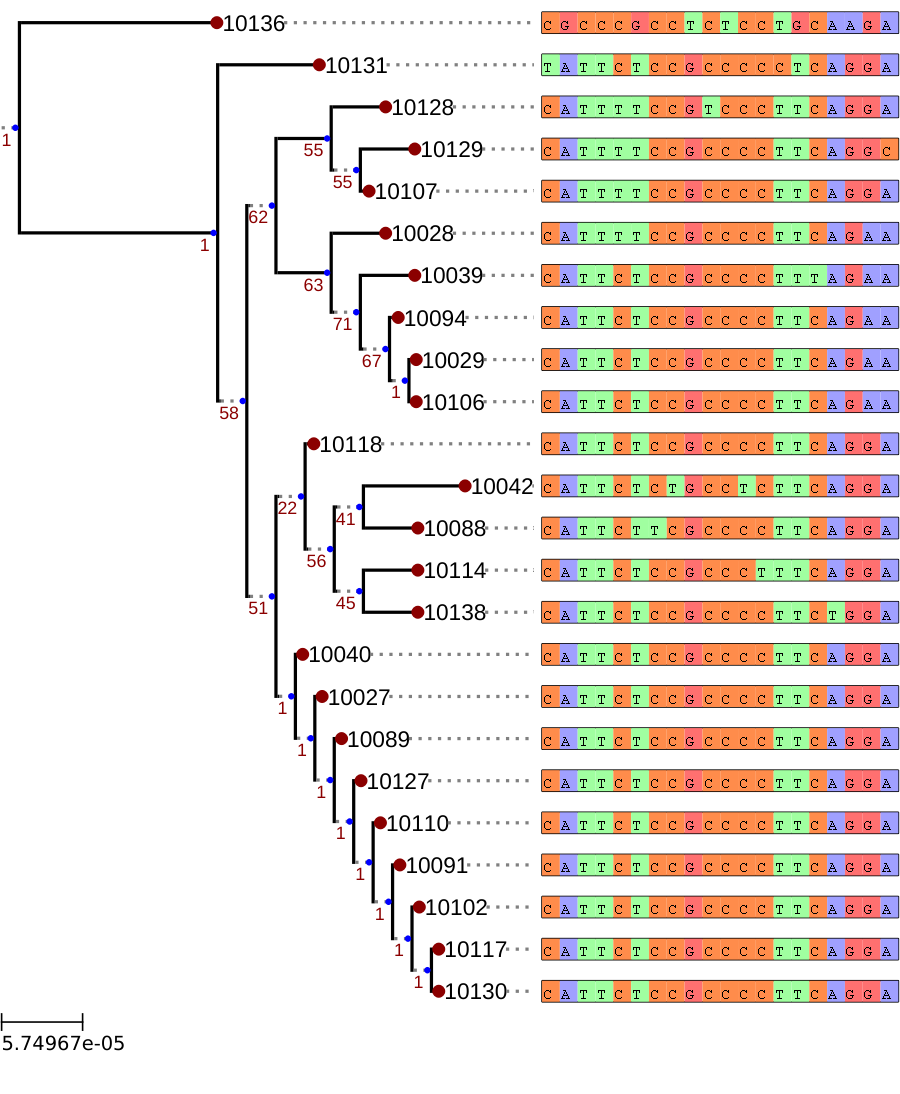

In [106]:

t.ladderize()
t.render("%%inline", w=10, units="in", tree_style = ts)     


### Global Analysis

*TODO: when rerunning this analysis, standardize the dates of each of the GISAID datasets*

This portion of the notebook contains an analysis of the boat sequences in a global and local context using sequences from GISAID.

Here is the metadata for all GISAID sequences as of `08-02-2021`: 

In [42]:
# Path to all of the fasta sequences in GISAID as of 08/04/21
all_fastas_path = "config/gisaid/2021-08-04_GISAID_sequences.fasta"

# Import all of the metadata from GISIAD 
GISAID_metadata = pd.read_table("config/gisaid/2021-08-02-GISAID-metadata.tsv")
GISAID_Epi_metadata = pd.read_table("config/gisaid/2021-08-03-GISAID-Epi-Metadata.tsv")

# Get the sequences that meet the quality standards
quality_sequences = GISAID_metadata[(GISAID_metadata['Is high coverage?'] == True) &
                                    (GISAID_metadata['N-Content'] <= 0.05) &
                                    (GISAID_metadata['Is complete?'] == True) &
                                    (GISAID_metadata['Host'] <= "Human")]


/home/whannon/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/whannon/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


#### GISAID Boat Comparison

These are just the sequences on the boat that we have replicate deep-sequencing runs for. It's also important to look at the remaining sequences (**15 samples with Ct > 20**). Also, I want to see where these sequences fall in the global phylogeny as well as the local washington phylogeny. 

To get as many of the relevant boat sequences as possible, I searched GISAID for all strains relevant to the boat. I took the 72 patient samples that we had data for from Pavitra and converted the internal SpID into a strain name to search in the GISAID metadata. 

In [43]:
# Read in the table from the supplement of https://doi.org/10.1128/JCM.02107-20
boat_metadata = pd.read_csv("config/data/Boat_Sample_Metadata.csv")
# List of strains to search GISAID for
strains_to_search  = [f"hCoV-19/USA/WA-UW-{spid}/2020" for spid in boat_metadata["SpID"]]
# Get the GISAID IDs from these strains
GISAID_metadata_boat = GISAID_metadata[GISAID_metadata['Virus name'].isin(strains_to_search)]
# Accessions for the boat samples
GISAID_boat_accessions = GISAID_metadata_boat['Accession ID'].tolist()
# Go through all of the fasta files to get the sequences for each of the samples on the boat. 
GISAID_boat_sequences = {record.name.split('/')[2].split("-")[-1]: record.seq for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in strains_to_search}

How similar are the consensus sequences on GISIAD to their counterparts from my analysis? 

In [44]:
for spid, genome in boat_genomes.items(): 
    
    # Get the gisaid version of the custom genome
    gisaid_genome = GISAID_boat_sequences[spid]
    
    # Make a record object for the custom genome
    custom_record = SeqRecord.SeqRecord(genome, id=f"custom")
    # Make a record object for the GISAD genome
    gisaid_record = SeqRecord.SeqRecord(gisaid_genome, id=f"gisaid")
    
    # Export the sequences to a fasta file for alignment
    SeqIO.write([custom_record, gisaid_record], "comparison.fa", "fasta")
    
    # Align the two sequences with Mafft
    mafft_cline = MafftCommandline(input="comparison.fa")
    stdout, stderr = mafft_cline()
    
    # Make a dictionary to compare the alignment
    alignment_dict = {record.name: "".join(base if base in 'atcgn-' else 'n' for base in record.seq) for record in SeqIO.parse(StringIO(stdout), 'fasta')}

    # Get the non gap or 'n' differences
    differences = [(pos, alleles[0], alleles[1]) for pos, alleles in enumerate(zip(alignment_dict['custom'], alignment_dict['gisaid'])) if alleles[0] != alleles[1] and alleles[0] not in "-n" and alleles[1] not in "-n"]

    print(f"\nFor patient {spid}, the differences between the custom and GISAID genome are:\n")
    for dif in differences: 
        print(f"Position: {dif[0]}, Custom: {dif[1]}, GISAID: {dif[2]}")
        
# When finished, remove the temporary fasta file. 
out = os.system("rm -f comparison.fa")
if out == 0: 
    print("\nRemoved temp fasta.")


For patient 10114, the differences between the custom and GISAID genome are:

Position: 29858, Custom: t, GISAID: a
Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10117, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10118, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10127, the differences between the custom and GISAID genome are:

Position: 12, Custom: t, GISAID: c
Position: 29860, Custom: g, GISAID: a
Pos

It seems like all of the single nucleotide differences between the GISAID sequences and the custom sequences are in where the Poly-A sequence starts. I can simply mask those bases when doing any kind of phylogenetic analysis with the extra sequences. 

In addition, there is a `c` at position `13` that seems to show up in the GISAID sequences. This is a difference with respect to the reference. I don't have this in the custom sequence. It would be a `T13C` change in some samples. There is one other discrepency in sample `10091` at position `36`. I have the base as a reference base `C` when they have a polymorphism at this position `C36T`. 

It seems possible that consensus at position `13` is `C`, but there is never enough coverage to annotate this. As for the `C36T` mutation in `10091`, that doesn't seem to exist (I looked in IGV for that sample). 

I assembled a fasta file with all of the sequences from our analysis and the remaining sequences from the boat. I masked the first 100 and last 100 nucleotides which tend to be divergent between the methods due to poor coverage. Another option is to change N's in the GISAID sequences into the reference nucleotides. I'm not sure if this will make a big difference. 

In [124]:
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/all-boat-sequences.aligned.fa.treefile"):
    # If not, make the appropriate files
    records = []
    
    for spid in set(list(boat_genomes.keys()) + list(GISAID_boat_sequences.keys())): 

        # Try to see if the patient has a genome record in the illumina assemblies. If not, get GISAID.
        try: 
            record = SeqRecord.SeqRecord((boat_genomes[spid]), id=spid)
        except: 
            record = SeqRecord.SeqRecord((GISAID_boat_sequences[spid]), id=spid)

        # Add the seq record to the list
        records.append(record)

    # Export the sequences to a fasta file for alignment
    SeqIO.write(records, "results/consensus/all-boat-sequences.fa", "fasta")

    make_tree(fastapath = "results/consensus/all-boat-sequences.fa", outpath = outpath, prefix = "all-boat-sequences", mask = True, large = True)



Aligning the fasta file: results/consensus/all-boat-sequences.fa

Finshed aligning file. Alignment is located at results/phylogeny/all-boat-sequences.aligned.fa

Building treefile: results/phylogeny/all-boat-sequences.aligned.fa.treefile

Finished building treefile.



Here is the tree with **all of the sequences from the boat**. I included any sequence for which there were duplicates. If there weren't duplicates, I included the assembled genome from GISAID.

*What's the best way to root this phylogenetic tree?*

If I exclude the the 5' and 3' UTRs from this tree because I'm unsure of the coverage of the samples that we didn't resequence. The outgroup looks like `10136` using midpoint rooting. This is consistent with our expectations. 
Furthermore, the tree isn't as noticibly split based on the assembly method (Custom vs. GISAID). 

Along with `10136`, `10115` is pretty distant from the rest of the boat sequences. 

In [202]:
## === Make the substitution matrix for internal nodes and tips === ##
# Adapted from J. Bloom 

alignment = "results/phylogeny/all-boat-sequences.aligned.fa"
state_file = "results/phylogeny/all-boat-sequences.aligned.fa.state"
site_offset = 265 # Start of ORF1ab 

# Get the genome sequences for each tip
tip_to_seq = {record.id: list(str(record.seq).upper()) for record in SeqIO.parse(alignment, 'fasta')}

# Convert the sequences into the same format of IQtree `-asr` .state file
tip_states = (
    pd.DataFrame.from_dict(tip_to_seq, orient='index')
    .rename_axis('Node')
    .reset_index()
    .melt(id_vars='Node',
          var_name='Site',
          value_name='State',
          )
    .assign(Site=lambda x: x['Site'] + 1)
    )

# Make the substitution matrix 
subs_matrices = {}

# Import the internal states from IQtree `-asr` .state file
internal_states = (
    pd.read_csv(state_file,
                sep='\t',
                comment='#',
                usecols=['Node', 'Site', 'State'])
    )

# Combine and format the internal and tip states
states = (
    internal_states
    .append(tip_states)
    .assign(Site = lambda x: x['Site'] + site_offset,
            n_states_at_site = lambda x: x.groupby('Site')['State'].transform('nunique'),
            )
    .query('n_states_at_site > 1')
    .drop(columns='n_states_at_site')
    )

states_dict = states.set_index(['Node', 'Site'])['State'].to_dict()

nodes = states['Node'].unique().tolist()

sites = sorted(states['Site'].unique())

# Find all pairwise differeces between the nodes/tips
subs_matrix = {}  # keyed by (parent, descendant)
for n1, n2 in itertools.product(nodes, nodes):
    subs = []
    for site in sites:
        nt1 = states_dict[(n1, site)]
        nt2 = states_dict[(n2, site)]
        if nt1 != nt2:
            if nt1 in {'A', 'C', 'G', 'T', "N"} and nt2 in {'A', 'C', 'G', 'T', "N"}:
                subs.append(f"{nt1}{site}{nt2}")
    subs_matrix[(n1, n2)] = ', '.join(subs)


In [203]:
# With midpoint rooting
t = Tree("results/phylogeny/all-boat-sequences.aligned.fa.treefile", format = 1)
 
# Tree style
ts = TreeStyle()
ts.show_branch_support = False
ts.branch_vertical_margin = 3
ts.scale = 10
ts.show_scale = False
 
nstyle_dict = {'hz_line_width': 1,
               'vt_line_width': 1,
               'hz_line_color': 'black',
               'vt_line_color': 'black',
               'size': 0}

# label nodes
for n in t.traverse():
    if n != t:
        subs = subs_matrix[(n.up.name.split("/")[0], n.name.split("/")[0])]
        icol = 0
        for sub in subs.split(', '):
            if sub:
                n.add_face(TextFace(f"{sub}  ",
                                         fsize=4,
                                         fgcolor="blue",),
                           column=icol,
                           position='branch-top',
                           )
                icol += 1
    
    nstyle = NodeStyle(**nstyle_dict)
    
    n.set_style(nstyle)

refnode = t.search_nodes(name='NC_045512.2')[0]
refnode.delete()


root_point = t.search_nodes(name='10136')[0]
t.set_outgroup(root_point)

t.render("results/phylogeny/all-boat-sequences.png", w=15, units="in", tree_style = ts)   

print("Sucess!")

Sucess!


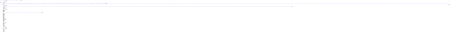

In [204]:
t.ladderize()
t.render("%%inline", w=5, units="in", tree_style = ts)  

### Context of the Outbreak

The next thing that I wanted to do was establish the context of the outbreak. I wanted to do this for two reasons. First, I want to demonstrate that the outbreak was monophyletic and stemed from a single introduction of SARS-CoV-2 on the boat that spread amoung passangers. Second, I want to see if intrahost mutations that arose on the boat showed up elsewhere in the local washington phylogeny. 

#### Global Phylogeny

Here, I want to show where the boat samples sit on the global phylogeny. To do this I included all circulating clades and samples that were close to the boat sequences specifically. The help with the visualization, I only incded a limited number of samples from each clade. 

*Ciculating clades up to the date of collection `05/03/2020` were: 19A, 19B, 20A, 20C, 20B, 20D, and 20F*

In [ ]:
# Clades circulating at the time of, or before, the outbreak on the boat. 
clades_of_interest = ['19A','19B','20A','20B','20C','20D','20E (EU1)','20F']

# Max number to sample from each clade
n_sample = 25

# List to contain the clade specific samples
clade_dfs = []

for clade in clades_of_interest: 
    # Get the accessions for every sequence in a given clade 
    accessions = GISAID_Epi_metadata[GISAID_Epi_metadata.Nextstrain_clade == clade].gisaid_epi_isl
    # Subtract the boat accessions
    accessions = set(accessions) - set(GISAID_boat_accessions)
    # Subset the metadata based on these sequences 
    clade_subset = GISAID_metadata[GISAID_metadata['Accession ID'].isin(accessions)]
    
    # Filter based on quality
    #high coverage
    clade_subset = clade_subset[clade_subset['Is high coverage?'] == True]
    #less than 5% N's 
    clade_subset = clade_subset[clade_subset['N-Content'] <= 0.05]
    #complete genome
    clade_subset = clade_subset[clade_subset['Is complete?'] == True]
    #host is human
    clade_subset = clade_subset[clade_subset['Host'] == "Human"]
    
    if len(clade_subset) > n_sample: 
        clade_subset = clade_subset.sample(n = n_sample, random_state = 7) # Set the seed for reproducibility
       
    clade_subset['clade'] = clade
    
    clade_dfs.append(clade_subset)
    

# Combine all of these representative sequences     
clade_df = pd.concat(clade_dfs)

clade_df.head()

#### BLAST Database

After I got representative sequences from each clade, I needed to get similar sequeucnes from `BLAST`. 

I will build a BLAST database using high quality sequences. It might make sense to save some of these python objects.


In [ ]:
# Check if this phylogeny already exists
if not os.path.exists("/results/phylogeny/blast_database.fasta"):
    
    # Make the BLAST database from high-quality sequences from before the collection date
    blast_sequence_metadata = GISAID_metadata[GISAID_metadata['Collection date'] <= '2020-05-30']
    #high coverage
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Is high coverage?'] == True]
    #less than 5% N's 
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['N-Content'] <= 0.05]
    #complete genome
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Is complete?'] == True]
    #host is human
    blast_sequence_metadata = blast_sequence_metadata[blast_sequence_metadata['Host'] == "Human"]
    #not including the boat sequences
    blast_sequence_metadata = blast_sequence_metadata[~blast_sequence_metadata['Accession ID'].isin(GISAID_boat_accessions)]

    # Get the virus names for the sequences to make the blast database and remove boat samples
    blast_virus_names = set(blast_sequence_metadata['Virus name'].tolist()) - set(GISAID_metadata_boat['Virus name'].to_list())
    # Get these sequences in a dictionary
    blast_virus_sequences = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in blast_virus_names]

    # Write these out to a fasta file 
    SeqIO.write(blast_virus_sequences, "results/phylogeny/blast_database.fasta", "fasta")
    print("(1/3) Finished downloading the eligible samples for the BLAST database.\n")

    # Build the BLAST database
    call(f"makeblastdb -in results/phylogeny/blast_database.fasta -dbtype nucl", shell=True)
    print("(2/3) Finished making the BLAST databse with the eligible samples.\n")

# For each boat genome, make the query fasta
all_matches_list = []
colnames = ["SpID", "Subject", "Perc_Identity", "Alignment_Length", "Mismatches", "Gap_Opens", "Q_start", "Q_end", "S_start", "S_end", "Evalue", "Bit_Score"]

for spid, genome in boat_genomes.items(): 
    custom_record = SeqRecord.SeqRecord(genome, id=spid)
    SeqIO.write(custom_record, "results/phylogeny/query.fasta", "fasta")
    
    # Query the database
    print(f"Querying the BLAST database for sample {spid}\n")
    call(f"blastn -db results/phylogeny/blast_database.fasta -query results/phylogeny/query.fasta -out results/phylogeny/results.out -outfmt 7", shell=True)
    
    # Import the table of matches and take the top ten
    match_df = pd.read_table("results/phylogeny/results.out", comment='#', names=colnames)
    #take the top 30 matches 
    match_df = match_df.head(50)
    #add to a list of dataframes
    all_matches_list.append(match_df)

print("(3/3) Finished BLASTing each sample.\n")
    
# Combine all of these and remove the duplicates
closest_sequences = pd.concat(all_matches_list).drop_duplicates(['Subject'])

# Remove the temp files
os.system("rm -f results/phylogeny/results.out results/phylogeny/query.fasta")


#### Representative Global Phylogeny 

This phylogeny contains sequences sampled from each clade circulating globally at the time of the outbreak. The phylogeny also contains the boat sequences as well as a non-redundant list of the top 50 matches to each sample by `BLASTN` (see above code). 

In [ ]:
# Add virus name to metadata
GISAID_Epi_metadata['Virus name'] = [f"hCoV-19/{strain}" for strain in GISAID_Epi_metadata.strain.tolist()]
# Clade colors 
clade_colors = {"19A":"blue", "19B":"green", "20A":"yellow", "20C":"orange", "20B":"pink", "20D":"purple", "20F":"black", "20E (EU1)":"grey"}
 
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/global_phylogeny.aligned.fa.treefile"):
    
    # Check if this fasta already exists
    if not os.path.exists("results/phylogeny/global_phylogeny.fa"):

        # Parse the sequence names from the dataframe
        blast_virus_names = [virus.split('|')[0] for virus in closest_sequences.Subject.tolist()]
        # Get these sequences from the GISAID metadata
        blast_df = GISAID_metadata[GISAID_metadata['Virus name'].isin(blast_virus_names)]
        # Concat with the clade sequences and boat sequences
        global_phylogeny_metadata = pd.concat([GISAID_metadata_boat, blast_df, clade_df])

        # 1. Get the virus names for the sequences to make the blast database and remove boat samples
        virus_names = set(global_phylogeny_metadata['Virus name'].tolist())
        # Get these sequences in a dictionary
        virus_sequences = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in virus_names]

        # Write these out to a fasta file 
        SeqIO.write(virus_sequences, "results/phylogeny/global_phylogeny.fa", "fasta")
        print("(1/3) Finished downloading the eligible samples for the global phylogeny.\n")

    make_tree(fastapath = "results/phylogeny/global_phylogeny.fa", outpath = outpath, prefix = "global_phylogeny")

# Visulize with ETE - color somehow. 
t = Tree("results/phylogeny/global_phylogeny.aligned.fa.treefile")

ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_support = True
ts.branch_vertical_margin = 10 

for n in t.traverse():
    if n.name.split("|")[0] in GISAID_metadata_boat['Virus name'].tolist():
        nstyle = NodeStyle()
        nstyle["fgcolor"] = "red"
        nstyle["size"] = 15
        n.set_style(nstyle)
    elif n.name.split("|")[0] in GISAID_Epi_metadata['Virus name'].tolist():
        nstyle = NodeStyle()
        nstyle["fgcolor"] = clade_colors[GISAID_Epi_metadata[GISAID_Epi_metadata['Virus name'] == n.name.split("|")[0]].Nextstrain_clade.item()]
        nstyle["size"] = 15
        n.set_style(nstyle)

ts.show_branch_length = True


t.render("results/phylogeny/representative-global-phylogeny.png", w=30, units="in", tree_style = ts)      

print("Sucess!")

In [ ]:

# Parse the sequence names from the dataframe
blast_virus_names = [virus.split('|')[0] for virus in closest_sequences.Subject.tolist()]
# Get these sequences from the GISAID metadata
blast_df = GISAID_metadata[GISAID_metadata['Virus name'].isin(blast_virus_names)]
# Concat with the clade sequences and boat sequences
global_phylogeny_metadata = pd.concat([GISAID_metadata_boat, blast_df, clade_df])

clade_info_df = pd.merge(global_phylogeny_metadata, GISAID_Epi_metadata, how="left", on=["Virus name"])




In [ ]:
for n in t.iter_leaves():
    n.name = n.name.split("|")[0]
    if n.name in clade_info_df[clade_info_df.Nextstrain_clade.isnull()]['Virus name'].tolist():
        n.delete()
       
    
clade_info_df = clade_info_df[~clade_info_df.Nextstrain_clade.isnull()]

for clade in set(clade_info_df.Nextstrain_clade):
    viruses = clade_info_df[clade_info_df.Nextstrain_clade == clade]["Virus name"].tolist()
    n = t.get_common_ancestor(viruses)
    nstyle = NodeStyle()
    nstyle["bgcolor"] = clade_colors[clade]
    n.set_style(nstyle)


In [ ]:

ts.mode = "c"
t.render("%%inline", w=30, units="in", tree_style = ts)      


In [ ]:
clade_colors

#### Washington Samples Around Outbreak

Here I've collected high quality samples from washinginton immediatly around the time of the outbreak. I used samples that were collected between the month before and the month after the outbreak on the boat. 

One goal of this analysis is to see if any minor variants from the boat became consensus variants later on in the tree. 

In [ ]:
# Check if this phylogeny already exists
if not os.path.exists("results/phylogeny/after_washington_phylogeny.aligned.fa.treefile"):
    
    # Check if this fasta already exists
    if not os.path.exists("results/phylogeny/after_washington_phylogeny.fa"):

        # Get all of the sequences from Washington up to 1 month before and after
        Washington_after_outbreak = GISAID_metadata[(GISAID_metadata['Collection date'] >= '2020-04-30') & (GISAID_metadata['Collection date'] <= '2020-06-30')]

        # Filter based on quality
        #high coverage
        Washington_after_outbreak = Washington_after_outbreak[Washington_after_outbreak['Is high coverage?'] == True]
        #less than 5% N's 
        Washington_after_outbreak = Washington_after_outbreak[Washington_after_outbreak['N-Content'] <= 0.05]
        #complete genome
        Washington_after_outbreak = Washington_after_outbreak[Washington_after_outbreak['Is complete?'] == True]
        #host is human
        Washington_after_outbreak = Washington_after_outbreak[Washington_after_outbreak['Host'] == "Human"]

        # Location is Washington State
        Washington_after_outbreak = Washington_after_outbreak[Washington_after_outbreak['Location'] == "North America / USA / Washington"]

        # Get the virus names for the sequences to make the blast database and remove boat samples
        washington_virus_names = set(Washington_after_outbreak['Virus name'].tolist()).union(set(GISAID_metadata_boat['Virus name'].to_list()))

        # Get these sequences in a dictionary
        washington_virus_sequences = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in washington_virus_names]
        # Write these out to a fasta file 
        SeqIO.write(washington_virus_sequences, "results/phylogeny/after_washington_phylogeny.fa", "fasta")
        print("(1/3) Finished downloading the eligible samples for the Washington 'after' phylogeny.\n")

        
    make_tree(fastapath = "results/phylogeny/after_washington_phylogeny.fa", outpath = outpath, prefix = "after_washington_phylogeny")

# Visulize with ETE - color somehow. 
t = Tree("results/phylogeny/after_washington_phylogeny.aligned.fa.treefile")

ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_support = True
ts.branch_vertical_margin = 10 

for n in t.traverse():
    if n.name.split("|")[0] in GISAID_metadata_boat['Virus name'].tolist():
        nstyle = NodeStyle()
        nstyle["fgcolor"] = "red"
        nstyle["size"] = 15
        n.set_style(nstyle)
        

boat_node = t.get_common_ancestor(GISAID_metadata_boat['Virus name'].tolist())
boat_style = NodeStyle()
boat_style["bgcolor"] = "red"
boat_node.set_style(boat_style)

ts.show_branch_length = True

t.render("results/phylogeny/washington-only-phylogeny.png", w=30, units="in", tree_style = ts)      


print("Sucess!")

In [ ]:

t.ladderize()
ts.mode = "c"
ts.arc_start = 360 # 0 degrees = 3 o'clock
ts.arc_span = 360
t.render("%%inline", w=30, units="in", tree_style = ts)      


#### Closer look at the boat clade.

From the above image, it's clear that sample `10136` belongs somewhere else on the phylogeny and was perhaps infected elsewhere on the boat. It also looks like sample `10115` doesn't belong to the monophyletic boat group. 

Another interesting observation is that two samples collected on the same day from the UW virology lab also show up as part of the boat clade. The branch length for one sample looks especially long. However, the other sample seems closer to the main one. These don't appear in the sample sheet for what was collected on the boat. That doesn't mean that they weren't resampled at a later date. 

Let's examine these two genomes. 

In [ ]:
# Get the names of the leaves corresponding to individuals on the boat
boat_leaf_names = [n.name for n in t.traverse() if n.name.split("|")[0] in GISAID_metadata_boat['Virus name'].tolist()]
# Remove the distant samples
for sample in ['hCoV-19/USA/WA-UW-10136/2020|2020-05-30|2020-06-06', 'hCoV-19/USA/WA-UW-10115/2020|2020-05-29|2020-08-09']:
    boat_leaf_names.remove(sample)
# Get the common ancestor of the boat samples and store as a subtree.
ancestor = t.get_common_ancestor(boat_leaf_names)

ancestor.render("%%inline", w=10, units="in", tree_style = ts)

t.check_monophyly(boat_leaf_names, "name")

What are the names of the two samples in this part of the subtree? 

In [ ]:
non_boat_samples = list()
for leaf in ancestor.iter_leaves(): 
    if leaf.name not in boat_leaf_names: 
        non_boat_samples.append(leaf.name.split("|")[0])
        

Two of the top 5 samples that weren't part of the boat have the longest branch lenghts. However, one of theses has a comparable branch length to other samples. 

How different are these samples from the deep-sequenced samples from the boat? The number of consensus differences can inform us about how likely these were to have resulted from direct transmission from any one of our samples.

In [ ]:
# Get the records for the non-boat genomes
non_boat_genomes = [record for record in SeqIO.parse(all_fastas_path, "fasta") if (record.id).split("|")[0] in non_boat_samples]

for record in non_boat_genomes: 
    SpID = record.name.split("/")[2].split('-')[-1]
    if SpID not in boat_genomes.keys():
        boat_genomes[SpID] = record.seq



In [ ]:

records = [SeqRecord.SeqRecord(seq[positions_to_include[0]:positions_to_include[1]], id=spid) for spid, seq in boat_genomes.items()]

records.append(SeqRecord.SeqRecord(Seq.Seq("".join(reference[positions_to_include[0]:positions_to_include[1]]).lower()), id = "reference"))

SeqIO.write(records, "results/phylogeny/with_outliers.fa", "fasta")
        
make_tree(fastapath = "results/phylogeny/with_outliers.fa", outpath = outpath, prefix = "with_outliers")


In [ ]:
# Hamming distance not including n's or gaps
distance2 = lambda x,y : sum(c1 != c2 for c1, c2 in zip(x, y) if "-" not in {c1, c2} and "n" not in {c1, c2})
# Get all of the aligned records as a dictionary. 
aligned_records = {record.id: str(record.seq) for record in SeqIO.parse("results/phylogeny/with_outliers.aligned.fa", "fasta")}
# Calculate all of the edit distances. 
edit_distance = {f"{g1}-{g2}": distance2(aligned_records[g1], aligned_records[g2]) for g1, g2 in combinations(aligned_records.keys(), 2) if "10136" not in {g1, g2}}

edit_distance  

In [ ]:
# Reference Sequence 
aligned_records = {record.id: str(record.seq) for record in SeqIO.parse("results/phylogeny/with_outliers.aligned.fa", "fasta")}
reference = [base.upper() for base in aligned_records['reference']]
aligned_records.pop("reference")

# Save a dict of the consensus SNPs for each patient
consesus = {}

# Populate the dict
for patient, genome in aligned_records.items():
    differences = []
    for i, bases in enumerate(zip(genome.upper(), reference)):
        if len(set(bases)) > 1 and "-" not in bases and "N" not in bases: 
            differences.append((i, bases))
    consesus[patient] = differences

# Get a set of all unique SNPs 
consensus_differences = set(snp for snp_list in consesus.values() for snp in snp_list)

# Fill in the missing SNPs in the dict
for patient, snps in consesus.items(): 
    for snp in consensus_differences: 
        if snp not in snps:
            consesus[patient].append((snp[0], (snp[1][1], snp[1][1])))


# Condense the identical sequences
unique_consensus = {}

for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][0] for snp in sorted(snps, key = (lambda s: s[0]))])
    if con in unique_consensus.keys():
        unique_consensus[con].append(patient)
    else: 
        unique_consensus[con] = [patient]

# Print the differences for each patient 
print(f"Position: {' '.join([str(snp[0]) for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
print(f"Reference: \t\t\t\t{' '.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")

for snps, patients in unique_consensus.items(): 
    print(f"{'/'.join(patients)}: \t\t\t\t\t{snps}")


Interestingly, there are 0 consensus differences between `10510` and three other samples `10129/10028/10107` if you disregard the first and last 100 nucleotides as well as n's or gaps in the sequence. Essentially, they seem to have identical SNPs. I'm not fully sure what this means for the samples on the boat.

In [ ]:
annots = {}
for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][0] for snp in sorted(snps, key = (lambda s: s[0]))])
    annots[patient] = con

print(annots)

In [ ]:
# Visulize with ETE - color somehow. 
t = Tree("results/phylogeny/after_washington_phylogeny.aligned.fa.treefile")

ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_support = True
ts.branch_vertical_margin = 10 

for n in t.iter_leaves():
    n.name = n.name.split("|")[0]

for n in t.traverse():
    if n.name in GISAID_metadata_boat['Virus name'].tolist():
        nstyle = NodeStyle()
        nstyle["fgcolor"] = "red"
        nstyle["size"] = 15
        n.set_style(nstyle)

boat_node = t.get_common_ancestor([g for g in GISAID_metadata_boat['Virus name'].tolist() if g not in {'hCoV-19/USA/WA-UW-10136/2020', 'hCoV-19/USA/WA-UW-10115/2020'}])
boat_style = NodeStyle()
boat_style["bgcolor"] = "#FF9C9C"
boat_node.set_style(boat_style)

ts.mode = "c"

t.render("%%inline", w=30, units="in", tree_style = ts)      


In [ ]:
GISAID_metadata_boat['Virus name'].tolist()

### END